#Loading Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier

ModuleNotFoundError: No module named 'pandas'

#Loading Dataset

**Breast Cancer Wisconsin (Diagnostic) Data Set**

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. Also can be found on UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

Attribute Information:

1) ID number

2) Diagnosis (M = malignant, B = benign)


(3-32) Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter)

b) texture (standard deviation of gray-scale values)

c) perimeter

d) area

e) smoothness (local variation in radius lengths)

f) compactness (perimeter^2 / area - 1.0)

g) concavity (severity of concave portions of the contour)

h) concave points (number of concave portions of the contour)

i) symmetry

j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features. For instance, field 3 is Mean Radius, field
13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant

In [4]:
df = pd.read_csv("data(1).csv")

In [5]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


#Preprocessing

The column "id" is irrelevant to the data and its output. Also, the column "Unnamed: 32" is a blank column.

So, both columns will be dropped.

In [6]:
df = df.drop('id', axis=1)
df = df.drop('Unnamed: 32', axis=1)

In [7]:
df.diagnosis.unique()

array(['M', 'B'], dtype=object)

In [8]:
df.diagnosis=(df.diagnosis=='M').astype(int)

The values in the dataset are far off from each other. They need to be normalised into range [0, 1].

We'll use the MinMaxScaler for normalising the data and RandomOverSampler to fill in the training set to eqaulize the no. of instances of unique outcome.

In [9]:
cols = list(df.columns)

In [10]:
def scale_dataset(x,y, oversample=False):
  sc= MinMaxScaler()
  x =sc.fit_transform(x)

  if oversample:
    ros= RandomOverSampler()
    x, y = ros.fit_resample(x, y)

  data = np.hstack((x,np.reshape(y, (len(y), 1))))
  return data, x, y

#Exploratory Analysis of dataset

In [11]:
df.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


<Axes: >

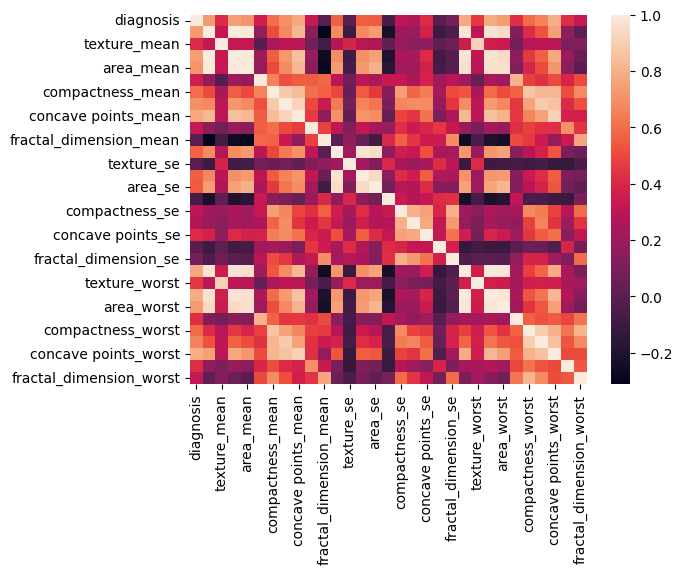

In [12]:
for label in df.columns[1:11]:
  plt.hist(df[df['diagnosis']==1][label], color = 'red', label ='M', alpha = 0.7, density = True)
  plt.hist(df[df['diagnosis']==0][label], color = 'green', label ='B', alpha = 0.7, density = True)
  #plt.title(label)
  #plt.ylabel("Probability")
  #plt.xlabel(label)
  #plt.legend()
  #plt.show()

corr= df.corr()
sns.heatmap(corr)


#Splitting Dataset

In [13]:
x_tr, x_ts, y_tr, y_ts = train_test_split(df[df.columns[1:]].values, df[df.columns[0]].values, test_size=0.3)

In [14]:
train, x_tr, y_tr = scale_dataset(x_tr, y_tr, True)
test, x_ts, y_ts = scale_dataset(x_ts, y_ts)

#Feature Selection

In [15]:
select_feature = SelectKBest(chi2, k=10).fit(x_tr, y_tr)
select_feature.scores_

array([2.49558559e+01, 5.09963553e+00, 2.62739971e+01, 2.68709420e+01,
       4.17007938e+00, 2.00921690e+01, 4.12217721e+01, 4.53303783e+01,
       3.55215583e+00, 5.29727490e-02, 1.62212355e+01, 2.91952913e-03,
       1.50069696e+01, 1.70533125e+01, 6.22563650e-04, 9.62403941e+00,
       4.87088082e+00, 8.83074596e+00, 1.01796754e-01, 2.97991322e+00,
       3.57686154e+01, 6.56904982e+00, 3.57405376e+01, 3.74236624e+01,
       5.76560888e+00, 1.83343660e+01, 2.76758386e+01, 4.03093673e+01,
       4.73505987e+00, 4.81467466e+00])

In [16]:
#X_tr=select_feature.transform(x_tr)
#X_ts=select_feature.transform(x_ts)
X_ts=x_ts
X_tr=x_tr

#Model Classification

In [17]:
skfold = StratifiedKFold(n_splits = 5)

In [18]:
def model_score_report(model,xtr,ytr,xts,yts):
  cvs=cross_val_score(model, xtr, ytr, cv= skfold)
  print("Stratified 5- fold : Cross-validation score:-")
  print(str(cvs)+"\nMean Score: "+str(cvs.mean()))
  model.fit(xtr, ytr)
  y_pred = model.predict(xts)

  print("\n70-30 split : Classification Report:-")
  print(classification_report(yts, y_pred))

##kNN

In [19]:
knn_model = KNeighborsClassifier(n_neighbors=5)
model_score_report(knn_model, X_tr, y_tr, X_ts, y_ts)

Stratified 5- fold : Cross-validation score:-
[0.96078431 0.99009901 0.97029703 0.98019802 0.97029703]
Mean Score: 0.9743350805668802

70-30 split : Classification Report:-
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       104
           1       0.85      0.93      0.89        67

    accuracy                           0.91       171
   macro avg       0.90      0.91      0.90       171
weighted avg       0.91      0.91      0.91       171



##Naive Bayes

In [20]:
nb_model = GaussianNB()
model_score_report(nb_model, X_tr, y_tr, X_ts, y_ts)

Stratified 5- fold : Cross-validation score:-
[0.93137255 0.92079208 0.95049505 0.94059406 0.94059406]
Mean Score: 0.9367695593088721

70-30 split : Classification Report:-
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       104
           1       0.84      0.88      0.86        67

    accuracy                           0.89       171
   macro avg       0.88      0.89      0.88       171
weighted avg       0.89      0.89      0.89       171



##Support Vector Machine

In [21]:
svm_model = SVC()
model_score_report(svm_model, X_tr, y_tr, X_ts, y_ts)

Stratified 5- fold : Cross-validation score:-
[0.97058824 0.99009901 0.97029703 0.97029703 0.97029703]
Mean Score: 0.9743156668608037

70-30 split : Classification Report:-
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       104
           1       0.90      0.96      0.93        67

    accuracy                           0.94       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171



##Logistic Regression

In [22]:
lg_model = LogisticRegression()
model_score_report(lg_model, X_tr, y_tr, X_ts, y_ts)

Stratified 5- fold : Cross-validation score:-
[0.96078431 0.98019802 0.97029703 0.97029703 0.97029703]
Mean Score: 0.9703746845272763

70-30 split : Classification Report:-
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       104
           1       0.88      0.96      0.91        67

    accuracy                           0.93       171
   macro avg       0.92      0.93      0.93       171
weighted avg       0.93      0.93      0.93       171



##Decision Tree

In [23]:
dt_model = DecisionTreeClassifier()
model_score_report(dt_model, X_tr, y_tr, X_ts, y_ts)

Stratified 5- fold : Cross-validation score:-
[0.93137255 0.96039604 0.96039604 0.99009901 0.99009901]
Mean Score: 0.9664725296059018

70-30 split : Classification Report:-
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       104
           1       0.95      0.90      0.92        67

    accuracy                           0.94       171
   macro avg       0.94      0.93      0.94       171
weighted avg       0.94      0.94      0.94       171



##Random Forest

In [27]:
rf_model = RandomForestClassifier(n_estimators= 10, criterion="entropy")
model_score_report(rf_model, X_tr, y_tr, X_ts, y_ts)

Stratified 5- fold : Cross-validation score:-
[0.95098039 0.99009901 0.96039604 0.97029703 0.98019802]
Mean Score: 0.9703940982333528

70-30 split : Classification Report:-
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       104
           1       0.94      0.91      0.92        67

    accuracy                           0.94       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171



#Ensemble

In [25]:
estimators = [('k-NeighborsClassifier',knn_model),('Naive_Bayes',nb_model),('Support Vector Machine',svm_model),
 ('Logistic Regression',lg_model),('Decision Tree',dt_model),('Random Forest',rf_model)]

In [26]:
ensemble_model = VotingClassifier(estimators)
model_score_report(ensemble_model, X_tr, y_tr, X_ts, y_ts)

Stratified 5- fold : Cross-validation score:-
[0.97058824 0.98019802 0.97029703 0.98019802 0.97029703]
Mean Score: 0.9743156668608037

70-30 split : Classification Report:-
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       104
           1       0.93      0.93      0.93        67

    accuracy                           0.94       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171



Done!!!!!!!!!!!!!!!